<a href="https://colab.research.google.com/github/remifol/SystematicReview/blob/master/SystematicReview_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#general importation
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import time
import random
import matplotlib.pyplot as plt
%matplotlib inline

#Natural Language processing
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model, svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, recall_score
import gensim
from gensim.models.word2vec import Word2Vec


#Pubmed tool importation
!pip install biopython
from Bio import Entrez
from Bio import Medline

#Other
from IPython.display import clear_output

from google.colab import drive
drive.mount('/content/drive')

clear_output() #for clarity

In [0]:
Entrez.email = 'nsauthier@gmail.com'  #email required for Entrez database request
Path = 'drive/My Drive/Projet de maitrise/Revue systématique/Automatisation/Algorithme/'

In [0]:
def cleaning(word_tokens):
  #goal: 
  stopWords = set(nltk.corpus.stopwords.words('english'))
  tokens = [token.lower() for token in word_tokens if token.isalpha()]
  porter_stemmer = PorterStemmer()
  tokens = [porter_stemmer.stem(token) for token in tokens if token not in stopWords]
  return " ".join(tokens)

def get_TitlesAbstracts(Data,subject,clean=True):
  #Use Entrez library to get title and abstract from Pubmed
  #Tokenize it, 
  #if clean=True clean it and return it as a formatted list
  #if not don't clean to be later processed by embedding
  
  #Initialization
  Data.AbstractTriageStatus
  TitlesAbstracts = []
  PMID_temp = []
  batchsize = 100
  print('Beginning of extraction of ' + subject)
  
  #Creation of dictionary PMID:label
  Label_dict = Data[Data.ReviewSubject == subject][['PMID','AbstractTriageStatus']].set_index('PMID').to_dict()['AbstractTriageStatus'] 
  
  PMID_list = Data.loc[Data['ReviewSubject'] == subject, 'PMID'].values

  for NB_PMID in range(len(PMID_list)): #go in batches to avoid overloading Entrez
    PMID_temp.append(str(PMID_list[NB_PMID]))
    if (NB_PMID % batchsize) == 1:
    
      #Get the generator for the PMID list on medline
      record = Medline.parse(Entrez.efetch(db='pubmed', id = ','.join(PMID_temp), rettype = 'medline'))

      #Extraction of title, abstract and up-dated PMID list
      for record in record:
        if 'AB' in record.keys():
          TitleAbstract_temp = []
          Unclean_TitleAbstract = record['TI'] + ' ' + record['AB']
          if clean:
            TitleAbstract_temp.append([cleaning(nltk.word_tokenize(Unclean_TitleAbstract.replace('-',' ')))])
          else:
            TitleAbstract_temp.append(Unclean_TitleAbstract)
          TitleAbstract_temp.append(Label_dict[int(record['PMID'])])
          TitleAbstract_temp.append(3) #For predicted lable
          TitlesAbstracts.append(TitleAbstract_temp)
      PMID_temp = []
      
  print('Subject ' + subject + ' extracted.')
      
  return TitlesAbstracts

def unpack(liste):
  #Transform a nested list into a numpy ndarray
  Number = len(liste)
  newlist = []
  label = []
  if isinstance(liste[0][0][0],str):#Input is a string of word
    for index in range(Number):
      newlist.append(liste[index][0][0])
      label.append(liste[index][1])
    return newlist, label
    
  else:
    for index in range(Number):
      newlist.append(liste[index][0])
      label.append(np.ones(liste[index][0].shape[0])*liste[index][1])
      
    return np.concatenate(newlist,axis=0), np.concatenate(label,axis=0)
  
def embed_w2v(model_link,TitlesAbstracts_list):
  w2v_model = gensim.models.KeyedVectors.load_word2vec_format(model_link, binary=True)
  print('model loaded')
  for text_num in range(len(TitlesAbstracts_list)):
    tokens = nltk.word_tokenize(TitlesAbstracts_list[text_num][0].replace('-',' '))
    stopWords = set(nltk.corpus.stopwords.words('english'))
    word_tokens = [token.lower() for token in tokens if token.isalpha()]
    embeded = []
    unknown_words = 0
    known_words = 0
    for word in word_tokens:
      try :
        embeded.append(w2v_model.get_vector(word))
      except KeyError: #unkown word
        embeded.append(np.zeros(300)) #unkown tag
        unknown_words+=1
      known_words += len(word_tokens)
  
    TitlesAbstracts_list[text_num][0] = np.asarray(embeded)
    
    TitlesAbstracts_list[text_num][2] = np.ones(len(embeded))*3 #predicted
    
    
    #change prediction vector
  
  print('Text embeded. {0:2.4f}% of unkown words'.format(unknown_words/(unknown_words+known_words)))

  return TitlesAbstracts_list

def metrics_calc(known,unkown):
  metrics = np.zeros([4,3])
  all_data = np.vstack((known, unkown))
  
  #know sensitivity
  metrics[0,0] = recall_score(known[:,0], known[:,1], pos_label=1)
  #know specificity
  metrics[1,0] =  recall_score(known[:,0], known[:,1], pos_label=0)
  #know f1
  if sum(known[:,1]) == 0:#to avoid warning when all predicted are =0
    metrics[2,0] =  0
  else:
    metrics[2,0] =  f1_score(known[:,0], known[:,1])
  #know proportion of included article
  metrics[3,0] =  np.sum(known[:,0])/len(known)
  #unkown sensitivity
  metrics[0,1] =  recall_score(unkown[:,0], unkown[:,1], pos_label=1)
  #unkown specificity
  metrics[1,1] =  recall_score(unkown[:,0], unkown[:,1], pos_label=0)
  #all f1
  if sum(unkown[:,1]) == 0:#to avoid warning when all predicted are =0
    metrics[2,1] =  0
  else:
    metrics[2,1] =  f1_score(unkown[:,0], unkown[:,1])
  #unkown proportion of included article
  metrics[3,1] =  np.sum(unkown[:,0])/len(unkown)
  #all sensitivity
  metrics[0,2] =  recall_score(all_data[:,0], all_data[:,1], pos_label=1)
  #all specificity
  metrics[1,2] =  recall_score(all_data[:,0], all_data[:,1], pos_label=0)
  #all f1
  if sum(all_data[:,1]) == 0:#to avoid warning when all predicted are =0
    metrics[2,2] =  0
  else:
    metrics[2,2] =  f1_score(all_data[:,0], all_data[:,1])
  #all proportion of included article
  metrics[3,2] =  np.sum(all_data[:,0])/len(all_data)
  
  return metrics

In [0]:
def model_iterative_fit(Model, batchsize, Unknown, order = "most"):

  #Random extraction of first data until one included article.
  Known = []
  random.shuffle(Unknown)
  label = True
  count = 0 #To have at least 2 articles
  while label or count < 1:
    temp = Unknown.pop()
    Known.append(temp)
    label = not(temp[1])
    count+=1

  #initialization
  Nb_iter = len(Unknown)//batchsize
  Metrics = np.zeros([4,3,Nb_iter]) #col=[SN, SP, %=0], Row = [Known, Unknown, All]

  #Iteration to include by article batches
  for i in range(Nb_iter):
    start = time.time()
    average = []
    random.shuffle(Known)
    Known_X, Known_Y = unpack(Known)
    _ = Model.fit(Known_X, Known_Y)

    #Decision function = distance from the SVM line for each unknown
    for unkown_id in range(len(Unknown)):
      Unknown[unkown_id][2] = Model.decision_function(Unknown[unkown_id][0])
      average.append(Unknown[unkown_id][2].mean())

    #Format of result as array with first col = true, second = predict
    result_temp = [] 
    for j in range(len(Unknown)):
      result_temp.append(np.array([Unknown[j][1],int((np.sign(np.sum(Unknown[j][2])) + 1)/2)]))
    result_unkown = np.reshape(result_temp, [len(result_temp),2])

    #Prediction of known with actual model
    for kown_id in range(len(Known)):
      Known[kown_id][2] = Model.decision_function(Known[kown_id][0])

    #Format of result as array with first col = true, second = predict
    result_temp = [] 
    for j in range(len(Known)):
      result_temp.append(np.array([Known[j][1],int((np.sign(np.sum(Known[j][2])) + 1)/2)]))
    result_known = np.reshape(result_temp, [len(result_temp),2])

    #Model Update
    for batch_id in range(batchsize):
      if order == "most": 
        #pop the most sure from the unkown to the known list
        Known.append(Unknown.pop(average.index(max(average))))
        _ = average.pop(average.index(max(average)))
      elif order == "random":
        #pop one article in the list that<s in a random order
        Known.append(Unknown.pop())

    #Metrics
    Metrics[:,:,i] = metrics_calc(result_known,result_unkown)

    if i%10 == 0:
      print('{0}/{1} articles. Iteration time: {2:2.4f} sec per batch'.format(i*batchsize,Nb_iter*batchsize, time.time()-start))
    
  return Metrics

In [0]:
#Extraction of the pre-formated tsv data
Data = pd.read_csv(Path+'epc-ir.clean.tsv', sep = '\t',names = ['ReviewSubject', 'Unknown', 'PMID','AbstractTriageStatus', 'ArticleTriageStatus'])
Data['AbstractTriageStatus'][Data['AbstractTriageStatus'] == 'I'] = 1 #included
Data['AbstractTriageStatus'][Data['AbstractTriageStatus'] != 1] = 0 #excluded
Subjects = Data['ReviewSubject'].unique()

TitlesAbstracts = get_TitlesAbstracts(Data, Subjects[0], clean = False)

Unknown = embed_w2v(Path+'Models/GoogleNews-vectors-negative300.bin.gz',TitlesAbstracts)

Beginning of extraction of ACEInhibitors
Subject ACEInhibitors extracted.
model loaded
Text embeded. 0.0014% of unkown words


In [0]:
svm_BOW = Pipeline([('vect', CountVectorizer(min_df=2)),
                    ('clf-svm', linear_model.SGDClassifier(loss = 'hinge',
                                                          penalty = 'l2', 
                                                          max_iter = 100, 
                                                          tol=1e-4,
                                                          class_weight = 'balanced',
                                                          )
                    )
                   ])

svm_W2V = linear_model.SGDClassifier(loss = 'log',
                                     penalty = 'l1', 
                                     max_iter =  1000,
                                     tol=1e-3,
                                     class_weight = 'balanced',
                                    warm_start = True)

subject = 'ACEI'
order = "most"
Metrics = model_iterative_fit(svm_W2V, batchsize = 10, Unknown=Unknown, order=order)

0/2190 articles. Iteration time: 0.9678 sec per batch
100/2190 articles. Iteration time: 2.8197 sec per batch
200/2190 articles. Iteration time: 3.6295 sec per batch
300/2190 articles. Iteration time: 4.3892 sec per batch
400/2190 articles. Iteration time: 7.0626 sec per batch
500/2190 articles. Iteration time: 6.9989 sec per batch
600/2190 articles. Iteration time: 7.7177 sec per batch
700/2190 articles. Iteration time: 11.2382 sec per batch
800/2190 articles. Iteration time: 10.1895 sec per batch
900/2190 articles. Iteration time: 10.2653 sec per batch
1000/2190 articles. Iteration time: 11.4792 sec per batch
1100/2190 articles. Iteration time: 13.8275 sec per batch
1200/2190 articles. Iteration time: 13.6860 sec per batch
1300/2190 articles. Iteration time: 16.2886 sec per batch
1400/2190 articles. Iteration time: 17.2070 sec per batch
1500/2190 articles. Iteration time: 18.4564 sec per batch
1600/2190 articles. Iteration time: 17.9950 sec per batch
1700/2190 articles. Iteration tim

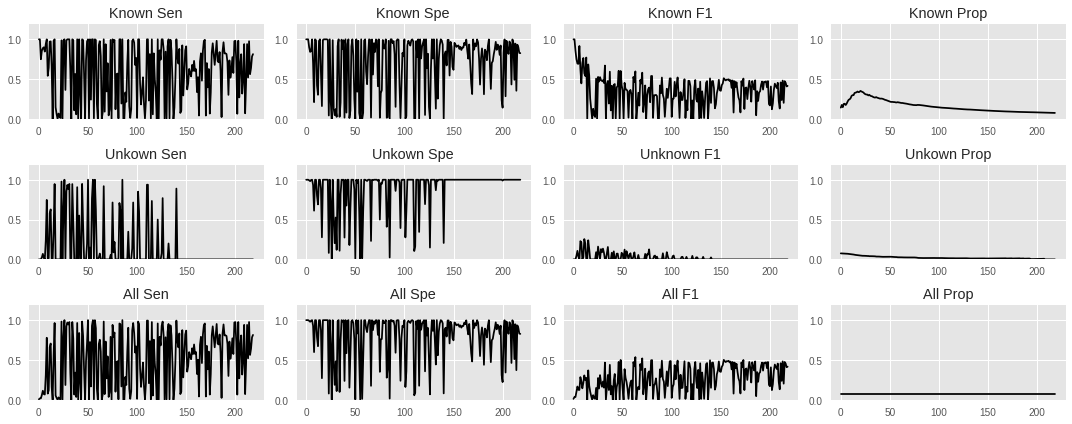

In [0]:
#Plot function
plt.style.use('ggplot')
x_axis = np.arange(0, max(Metrics.shape))

fig, ax = plt.subplots(3,4, figsize=(15, 6), facecolor='w', edgecolor='k')#figsize=(10,5), dpi=150)

titles = ('Known Sen',
          'Known Spe',
          'Known F1',
          'Known Prop',
          'Unkown Sen',
          'Unkown Spe',
          'Unknown F1',
          'Unkown Prop',
          'All Sen',
          'All Spe',
          'All F1',
          'All Prop')

ax = ax.ravel()

for i in range(12):
  color = 'tab:black'
  
  ax[i].set_title(titles[i])
  ax[i].plot(x_axis,Metrics[i%4,i//4,:], 'k')
  ax[i].set_ylim(0,1.2)


#ax1.legend(loc='right')
fig.tight_layout()
plt.show()

In [0]:
 #Version 2: Partial Fit
#TO BE BETTERED

#initialization
batchsize = 10
Nb_iter = len(Unknown)//batchsize
Metrics = np.zeros([4,3,Nb_iter]) #col=[SN, SP, %=0], Row = [Known, Unknown, All]
#Initialization of sklearn model
svm_W2V = linear_model.SGDClassifier(loss = 'log',
                                     penalty = 'l2', 
                                     max_iter =  1000,
                                     tol=1e-4)
                                     #class_weight = 'balanced')

#First pass with the first batch with 1 included
Known_X, Known_Y = unpack(Known)
svm_W2V.partial_fit(Known_X, Known_Y, classes=np.array([0,1]))

#Iteration to include by article batches
for i in range(Nb_iter):
  start = time.time()
  average = []
  #Decision function = distance from the SVM line for each unknown
  for unkown_id in range(len(Unknown)):
    Unknown[unkown_id][2] = svm_W2V.decision_function(Unknown[unkown_id][0])
    average.append(Unknown[unkown_id][2].mean())
  
  #Format of result as array with first col = true, second = predict
  result_temp = [] 
  for j in range(len(Unknown)):
    result_temp.append(np.array([Unknown[j][1], int((np.sign(np.sum(Unknown[j][2])) + 1)/2)]))
  result_unkown = np.reshape(result_temp, [len(result_temp),2])
  
  #Prediction of known with actual model
  for kown_id in range(len(Known)):
    Known[kown_id][2] = svm_W2V.decision_function(Known[kown_id][0])

  #Format of result as array with first col = true, second = predict
  result_temp = [] 
  for j in range(len(Known)):
    result_temp.append(np.array([Known[j][1],int((np.sign(np.sum(Known[j][2])) + 1)/2)]))
  result_known = np.reshape(result_temp, [len(result_temp),2])
  
  #Model Update
 
  #Selection of the batch of new articles with the most certainty
  #to ask the label. Simulated by tranfering them in the known list
  #and adding their weight to the model
  for batch_id in range(batchsize):
    #pop the most sure from the unkown to the known
    temp = []
    temp.append(Unknown.pop(average.index(max(average))))
    temp_x, temp_y = unpack(temp)
    svm_W2V.partial_fit(temp_x, temp_y)
    Known.append(temp[0])
    _ = average.pop(average.index(max(average)))
    
    
  #Metrics
  Metrics[:,:,i] = metrics_calc(result_known,result_unkown)

  if i%10 == 0:
    print('{0}/{1}. Iteration time: {2:2.4f} sec.'.format(i,Nb_iter, time.time()-start))